# Day 18: Handling Sequential Data in PyTorch
---

## 1. Introduction to Sequential Data

Sequential data is characterized by an inherent order in time or space. The sequence of data points carries meaningful dependencies that must be preserved during modeling.

### Examples of Sequential Data
- **Time Series**: Stock prices, weather data, electricity usage
- **Text**: Word order determines sentence meaning
- **Audio**: Temporal structure defines sound reproduction

---

## 2. Use Case: Electricity Consumption Prediction

The task involves predicting electricity usage based on historical patterns.

- **Dataset**: ElectricityLoadDiagrams20112014 from UCI Machine Learning Repository
- **Granularity**: Data recorded every 15 minutes
- **Duration**: Four years of continuous readings
- **Target**: Predict the next consumption value based on prior readings

Reference:  
Trindade, Artur. (2015). ElectricityLoadDiagrams20112014. [UCI Repository](https://doi.org/10.24432/C58C86)

---

## 3. Train-Test Split for Sequential Data

Unlike random splits used in tabular data, sequential data requires time-aware partitioning to avoid look-ahead bias.

### Strategy
- **Training Set**: First three years of data
- **Test Set**: Fourth year of data
- **Rationale**: Mimics real-world forecasting where future data is unknown during training

---

## 4. Sequence Construction

To train a model on sequential data, we must convert raw time series into input-output pairs.

### Sequence Parameters
- **Forecast Horizon**: Predict one step ahead
- **Input Window**: Previous 24 hours
- **Sampling Rate**: 15-minute intervals
- **Sequence Length**: \(24 \times 4 = 96\) data points

### Input-Target Mapping
- **Input**: 96 consecutive consumption values
- **Target**: The next consumption value immediately following the input window

---

## 5. Sequence Generation Logic

A function is used to generate training examples:

- Iterate over the time series
- For each valid position:
  - Extract a window of 96 data points as input
  - Assign the next data point as the target
- Store inputs and targets in separate lists
- Convert lists to NumPy arrays for model ingestion

This process ensures that each training example reflects a realistic forecasting scenario.

---

## 6. Dataset Conversion with TensorDataset

Once sequences are generated:

- Convert NumPy arrays to PyTorch tensors using `torch.from_numpy`
- Cast to `float` for compatibility with model layers
- Wrap inputs and targets in a `TensorDataset`
- Use `DataLoader` for batching and shuffling during training

This setup mirrors standard PyTorch workflows for tabular and image data.

---

## 7. Broader Applicability

The same principles apply to other types of sequential data:

| Domain             | Task Example                          | Model Objective                        |
|--------------------|----------------------------------------|----------------------------------------|
| Text               | Next word prediction                   | Language modeling                      |
| Audio              | Speech-to-text transcription           | Sequence-to-sequence learning          |
| Sensor Data        | Predict next sensor reading            | Time series forecasting                |

Sequence modeling is foundational to many modern AI systems, including Large Language Models and speech recognition engines.

---

## 8. Summary of Key Concepts

| Concept                  | Description                                             |
|--------------------------|---------------------------------------------------------|
| Sequential Data          | Ordered data with temporal or spatial dependencies      |
| Time-Aware Splitting     | Prevents look-ahead bias in forecasting tasks           |
| Sequence Construction    | Converts raw series into input-target training pairs    |
| TensorDataset            | Wraps tensors for use with PyTorch DataLoader           |
| Generalization           | Applicable to text, audio, and other sequential domains |

---

## 9. Final Notes

Today’s session introduced the core mechanics of sequence modeling in PyTorch. By chunking time series into structured training examples and respecting temporal order, we lay the groundwork for building models that learn from patterns over time. These techniques extend naturally to text, audio, and other domains where sequence matters.


## Generating sequences

To be able to train neural networks on sequential data, you need to pre-process it first. You'll chunk the data into inputs-target pairs, where the inputs are some number of consecutive data points and the target is the next data point.

Your task is to define a function to do this called create_sequences(). As inputs, it will receive data stored in a DataFrame, df and seq_length, the length of the inputs. As outputs, it should return two NumPy arrays, one with input sequences and the other one with the corresponding targets. 

In [1]:
import numpy as np

def create_sequences(df, seq_length):
    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(df)-seq_length):
      	# Define inputs
        x = df.iloc[i:(i+seq_length), 1]
        # Define target
        y = df.iloc[i+seq_length, 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

## Sequential Dataset

Just like tabular and image data, sequential data is easiest passed to a model through a torch Dataset and DataLoader. To build a sequential Dataset, you will call create_sequences() to get the NumPy arrays with inputs and targets, and inspect their shape. Next, you will pass them to a TensorDataset to create a proper torch Dataset, and inspect its length. 

In [9]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset

# Load data
train_data = pd.read_csv('electricity_train.csv')
test_data = pd.read_csv('electricity_test.csv')

print("Train data shape:", train_data.shape)   # e.g., (10000, 1)
print("Test data shape:", test_data.shape)

Train data shape: (105215, 2)
Test data shape: (35040, 2)


In [10]:
import torch
from torch.utils.data import TensorDataset

# Use create_sequences to create inputs and targets
X_train, y_train = create_sequences(train_data, seq_length=96)
print(X_train.shape, y_train.shape)

# Create TensorDataset
dataset_train = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float(),
)
print(len(dataset_train))

(105119, 96) (105119,)
105119


## 1. Recurrent Neuron: Concept

Unlike feed-forward networks where data flows in one direction, RNNs introduce feedback connections:

- At each time step:
  - Input \( x_t \) is processed
  - Output \( y_t \) is produced
  - Hidden state \( h_t \) is updated and passed to the next time step

This feedback loop enables **temporal memory**, allowing the network to retain information across time steps.

In PyTorch, a recurrent neuron is implemented using `nn.RNN`.

---

## 2. Unrolling Through Time
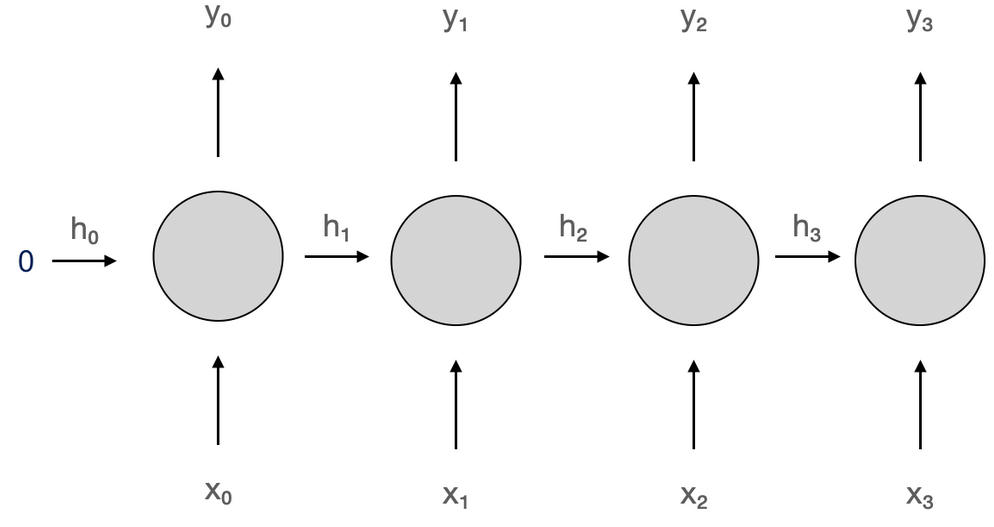
To visualize RNN behavior, we **unroll the neuron** across time steps:

- **Time Step 0**: Input \( x_0 \), hidden state \( h_0 = 0 \)
- **Time Step 1**: Input \( x_1 \), hidden state \( h_1 \)
- ...
- **Time Step T**: Input \( x_T \), hidden state \( h_T \)

Each output depends on **all previous inputs**, enabling the model to capture sequential dependencies.

---

## 3. Deep RNNs

Stacking multiple RNN layers creates a **deep recurrent neural network**:
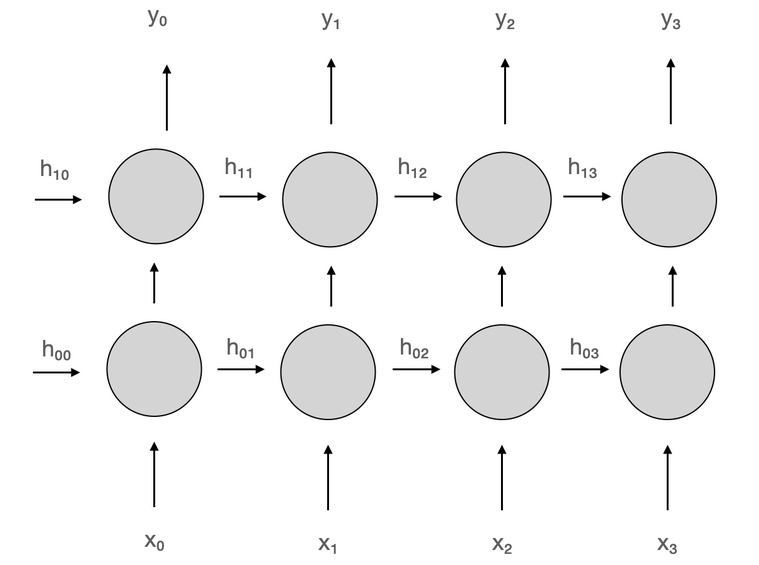
- Each layer processes the output of the previous layer
- Enables hierarchical feature extraction over time
- Analogous to stacking layers in dense or convolutional networks

---

## 4. Sequence Modeling Architectures

Different tasks require different input-output sequence mappings:

### A. Sequence-to-Sequence
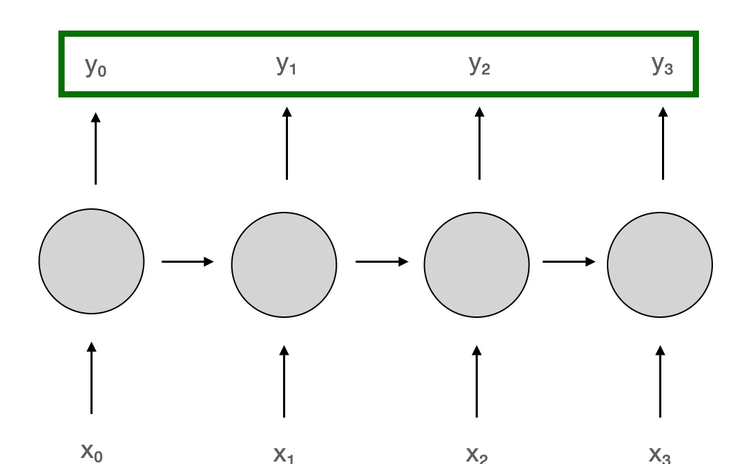
- Input: Full sequence
- Output: Sequence of predictions at each time step
- Example: Real-time speech recognition

### B. Sequence-to-Vector
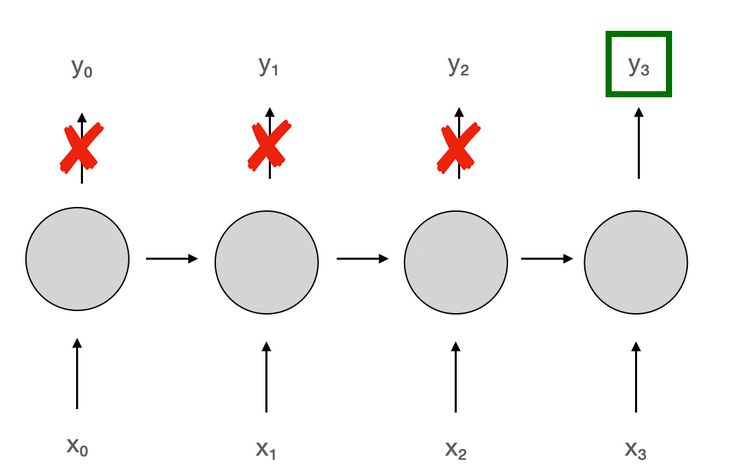
- Input: Full sequence
- Output: Single prediction from final time step
- Example: Text classification, electricity consumption forecasting

### C. Vector-to-Sequence
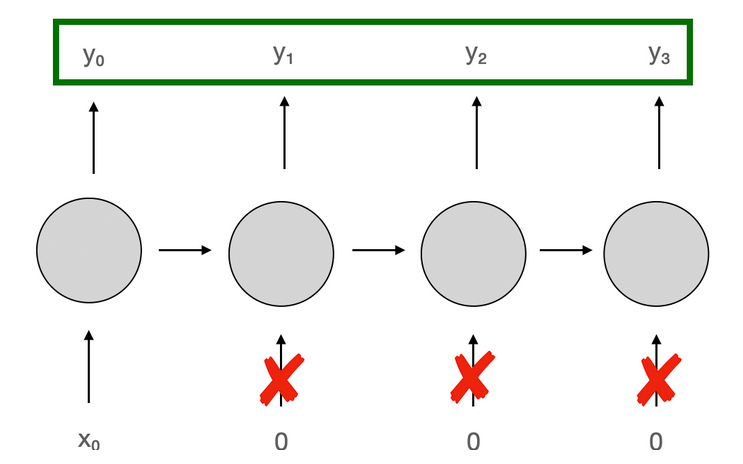
- Input: Single vector
- Output: Sequence of predictions
- Example: Text generation from a topic or sentiment vector

### D. Encoder-Decoder
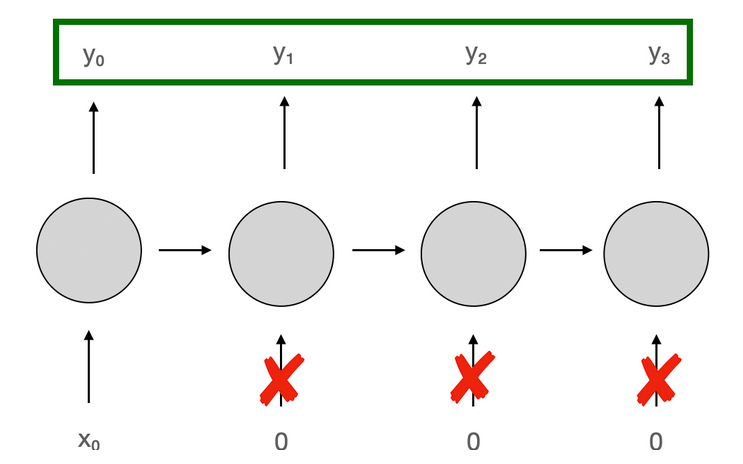
- Input: Full sequence
- Output: Sequence generated after input is fully processed
- input and out put one at a time
- Example: Machine translation

---

## 5. Sequence-to-Vector RNN in PyTorch

### Model Components
- **RNN Layer**:
  - Input size: 1 (electricity consumption)
  - Hidden size: 32
  - Number of layers: 2
  - `batch_first=True` for batch-major input format

- **Linear Layer**:
  - Maps final hidden output to a scalar prediction

### Forward Pass Logic
- Initialize hidden state \( h_0 \) as zeros
- Pass input sequence and \( h_0 \) to RNN
- Extract final output from last time step
- Pass through linear layer to produce prediction

This architecture enables forecasting based on temporal patterns in electricity usage.

---

## 6. Summary of Key Concepts

| Concept                   | Description                                             |
|---------------------------|---------------------------------------------------------|
| Recurrent Neuron          | Maintains hidden state across time steps               |
| Unrolling Through Time    | Visualizes temporal flow of data and memory            |
| Deep RNNs                 | Stacked layers for hierarchical sequence modeling       |
| Sequence Architectures    | Tailored input-output mappings for different tasks      |
| PyTorch RNN Implementation| Sequence-to-vector model for time series forecasting    |

---

## 7. Final Notes

Recurrent Neural Networks are foundational for modeling sequential data. Today’s session introduced 
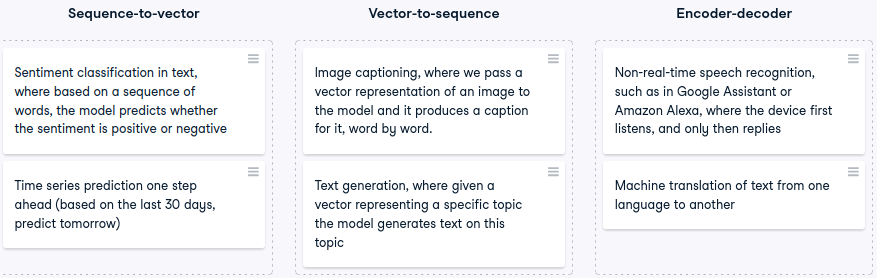

In [12]:
import torch.nn as nn
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define RNN layer
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

In [25]:
 def forward(self, x):
        # Initialize first hidden state with zeros
        h0 = torch.zeros(2, x.size(0), 32)
      # Pass x and h0 through recurrent layer

        out, _ = self.rnn(x,h0)
        # Pass recurrent layer's last output through linear layer
        out = self.fc(out[:, -1, :])
        return out

#  RNN, LSTM, and GRU Cells in PyTorch


## 1. Short-Term Memory Problem in RNNs

RNNs maintain a hidden state across time steps, enabling them to model sequential dependencies. However:

- The hidden state tends to **forget earlier inputs** as the sequence grows longer.
- This leads to **short-term memory**, making RNNs ineffective for tasks requiring long-range context.
- Example: Translating a long sentence — the model may forget the beginning by the time it reaches the end.

To address this, two enhanced architectures were introduced:
- **LSTM (Long Short-Term Memory)**
- **GRU (Gated Recurrent Unit)**

---

## 2. Plain RNN Cell

At each time step \( t \), the RNN cell performs:
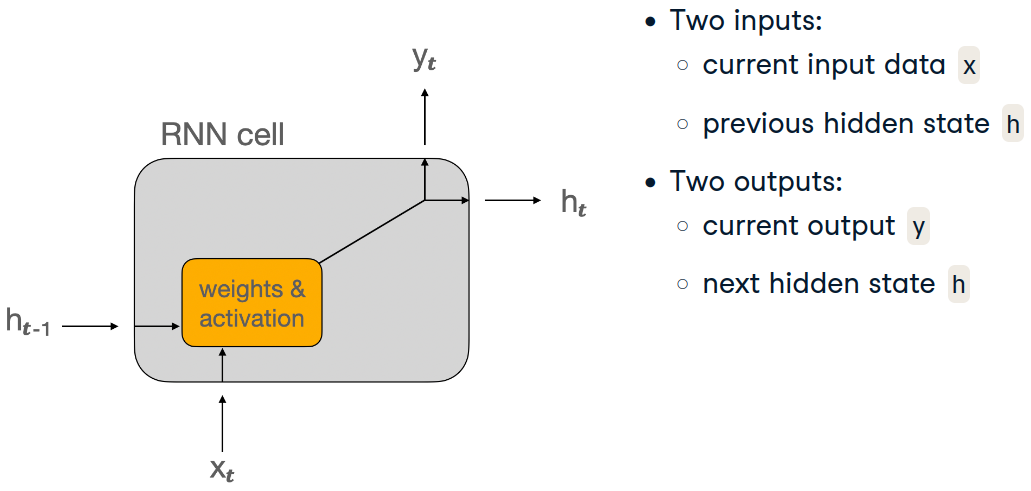- Input: \( x_t \) and previous hidden state \( h_{t-1} \)
- Operation: Weighted combination and activation
- Output: Current output \( y_t \) and updated hidden state \( h_t \)

This structure is simple but suffers from vanishing gradients and limited memory span.

---

## 3. LSTM Cell: Long-Term Memory Integration

LSTM introduces two hidden states:
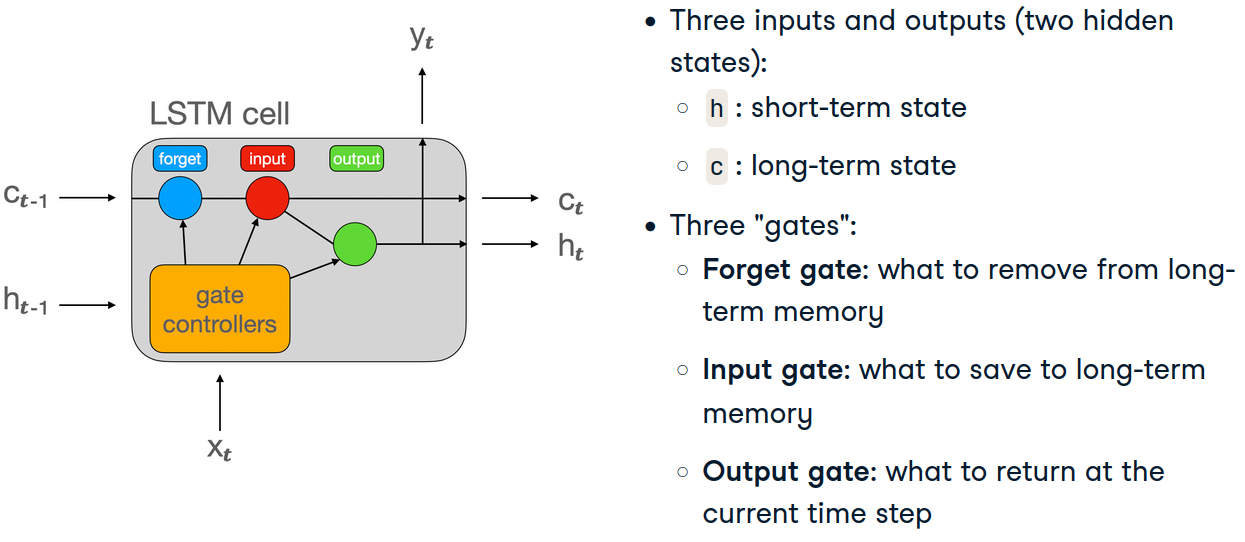
- **Short-term memory**: \( h \)
- **Long-term memory**: \( c \)

### Gate Mechanisms
- **Forget Gate**: Decides which parts of \( c \) to erase
- **Input Gate**: Selects new information to add to \( c \)
- **Output Gate**: Determines the current output \( y \)

### Outputs
- Updated long-term memory \( c \)
- Short-term memory \( h \), which also serves as output \( y \)

This architecture enables retention of information across long sequences.

---

## 4. LSTM Implementation in PyTorch

- Replace `nn.RNN` with `nn.LSTM`
- Initialize both hidden states \( h_0 \) and \( c_0 \) as zero tensors
- Pass them as a tuple to the LSTM layer
- Extract the final output and pass through a linear layer

This mirrors the structure of a sequence-to-vector model.

---

## 5. GRU Cell: Simplified Memory Control

GRU simplifies LSTM by:
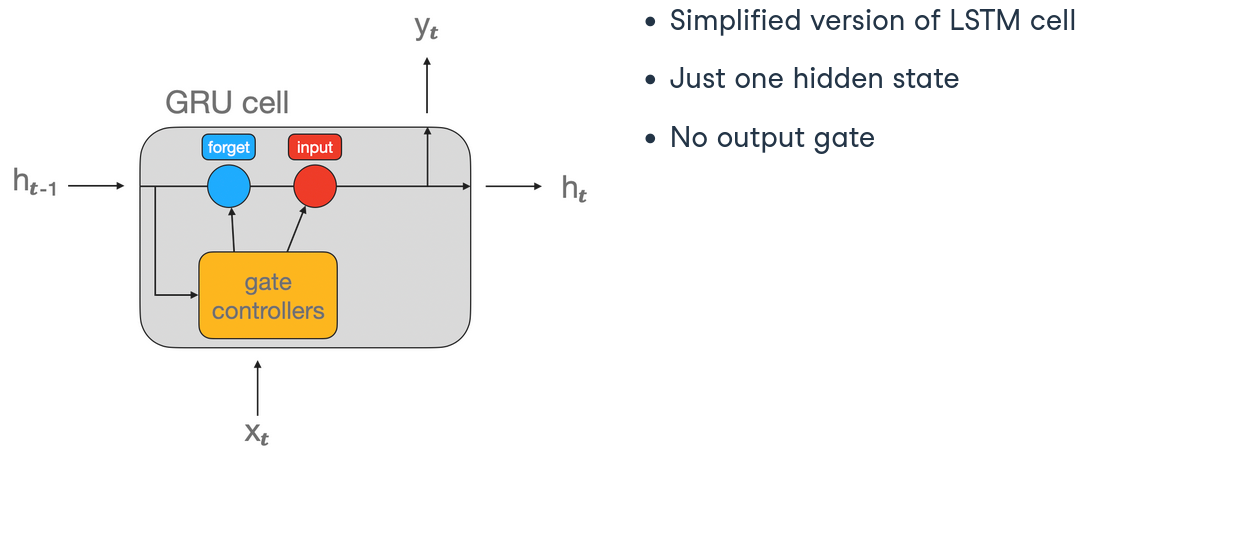
- Merging short-term and long-term memory into a **single hidden state**
- Eliminating the **output gate**

At each time step, the entire hidden state is returned. This reduces computational complexity while retaining performance.

---

## 6. GRU Implementation in PyTorch

- Replace `nn.RNN` with `nn.GRU`
- Use a single hidden state \( h \)
- Forward pass logic remains similar to RNN and LSTM

GRU is often preferred for faster training and fewer parameters.

---

## 7. Choosing Between RNN, LSTM, and GRU

| Architecture | Memory Type       | Complexity | Use Case Considerations                     |
|--------------|-------------------|------------|---------------------------------------------|
| RNN          | Short-term only   | Low        | Rarely used due to memory limitations        |
| LSTM         | Short + Long-term | High       | Effective for long sequences, more compute   |
| GRU          | Unified memory    | Medium     | Efficient, often comparable to LSTM         |

### Recommendation
- **Understand RNNs** for foundational knowledge
- **Try both LSTM and GRU** in practice
- **Evaluate performance** based on task and dataset

---

## 8. Summary of Key Concepts

| Concept               | Description                                             |
|-----------------------|---------------------------------------------------------|
| Short-Term Memory     | RNNs forget early inputs in long sequences              |
| LSTM Cell             | Uses gates to manage long-term and short-term memory    |
| GRU Cell              | Simplified version of LSTM with unified memory          |
| PyTorch Implementation| Swap RNN with LSTM or GRU and adjust hidden states      |
| Model Selection       | Depends on task complexity and sequence length          |

---

## 9. Final Notes

Today’s session deepened the understanding of recurrent architectures and their memory mechanisms. By comparing RNN, LSTM, and GRU, we now have the tools to choose and implement the right model for sequence-based tasks such as forecasting, translation, and classification.


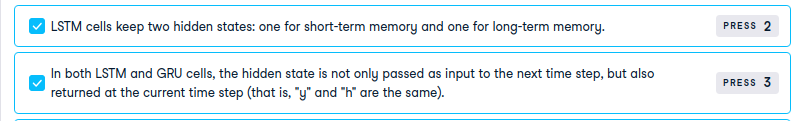

In [26]:
class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Define lstm layer
        lstm = nn.LSTM(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        # Initialize long-term memory
        c0 = torch.zeros(2, x.size(0), 32)
        # Pass all inputs to lstm layer
        out, _ = self.lstm(X,size(0), 32)
        out = self.fc(out[:, -1, :])
        return out

In [27]:
class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Define lstm layer
        lstm = nn.LSTM(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        
        self.fc = nn.Linear(32, 1)


        def forward(self, x):
            batch_size = x.size(0)
            h0 = torch.zeros(2, batch_size, 32, device=x.device)
            c0 = torch.zeros(2, batch_size, 32, device=x.device)
            out, _ = self.lstm(x, (h0, c0))  # Pass as tuple
            out = self.fc(out[:, -1, :])
            return out

In [28]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define RNN layer
        self.gru = nn.GRU(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.gru(x, h0)  
        out = self.fc(out[:, -1, :])
        return out